<a href="https://colab.research.google.com/github/FHnt97/RUG_TOM_SIO/blob/main/Copy_of_Assignment_A_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment A.4 
## Part 2

**Authors:** Group 2.1

*   V. Stupko			S2367246
*   S. Zuidhoek			S4190947
*   R. van der Straten		S3125327	
*   F. Höhne Tarragona		S4605632

**Course:** Smart Industry Operations *EBM223A05.2021-2022.1B*

**Lecturer:** *Dr Christos Emmanouilidis*

***2022-01-14***

<br>

In this part of the assignment, we are asked to classify data into "accept offer", and "don't accept offer" based on historical data. 

We have been given another set of employees which are preselected, and instead of making them a specific offer, we are asking them to request a certain salary level. We assume that the data is to be modelled onto document A.4 (not A-2 as described in the instructions). 

The objective is to analyse whether or not their salary expectations are within reason and will be accepted. 

The 400 rows of trianing data have the column checked - salaries that are within range are accepted (1), salaries outside of range are regected (0). 

The report is divided into sections as follows:
1. Importing op libraries and data
2. Data analysis and basic data clearning
3. Exploraroty analysis of data (correclation analysis)
4. Set-up of classification model - supervised learning
5. Results and conclusion



---



## 1. Importing of libraries and data set

In [101]:
# import all needed libraries

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# sns visualisation set up
%matplotlib inline
sns.set_style('darkgrid')


from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [102]:
# conenct to drive to access files in the sharedrive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
# read csv 
df_train = pd.read_csv('/content/drive/Shareddrives/SIO - Group 2.1 (S1b)/A4 (14.01.2022)/A4_3.csv', sep=',')
df_test = pd.read_csv('/content/drive/Shareddrives/SIO - Group 2.1 (S1b)/A4 (14.01.2022)/A4_4.csv', sep=',')



---


## 2. Initial data analysis and cleaning

For the initial data analysis, we will look solely for extreme discrepancies in the dataset. This includes:
- if needed, removing NaN values
- ensuring the correct Dtype for further data analysis
- if needed, removing outliers in the data (negative values)
- if needed, re-naming attribtues in order to better classify records (gender, department, education level)


This process will be carried out with both the test, and the train dataset.

In [104]:
# check for correct formatting of cells
# check for Na values (no NaNs in dataset therefore no further action is taken)
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecID                400 non-null    object 
 1   First Name           400 non-null    object 
 2   Surname              400 non-null    object 
 3   Gender               400 non-null    object 
 4   Age                  400 non-null    float64
 5   Date of birth        400 non-null    object 
 6   Years of experience  400 non-null    float64
 7   Education Level      400 non-null    float64
 8   Department           400 non-null    object 
 9   Country              400 non-null    object 
 10  Performance          400 non-null    float64
 11  EN                   400 non-null    float64
 12  F                    400 non-null    float64
 13  SP                   400 non-null    float64
 14  NL                   400 non-null    float64
 15  GE                   400 non-null    flo

In [105]:
# drop NaNs 
df_train = df_train.dropna()


In [106]:
# df_train.columns
df_test.columns

Index(['RecID', 'First Name', 'Surname', 'Gender', 'Age', 'Date of birth',
       'Years of experience', 'Education Level', 'Department', 'Country',
       'Performance', 'EN', 'F', 'SP', 'NL', 'GE', 'IT', 'Assembly',
       'Machining', 'Welding', 'Additive', 'Painting', 'Control', 'Quality',
       'Planning', 'Services', 'Shipping', 'Total'],
      dtype='object')

In [107]:
# change 'Date of birth' to DateTime
df_train['Date of birth'] = pd.to_datetime(df_train['Date of birth'])
df_test['Date of birth'] = pd.to_datetime(df_test['Date of birth'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [108]:
# check for consistent input in cells
# df_train.head()
df_test.head()

,RecID,First Name,Surname,Gender,Age,Date of birth,Years of experience,Education Level,Department,Country,Performance,EN,F,SP,NL,GE,IT,Assembly,Machining,Welding,Additive,Painting,Control,Quality,Planning,Services,Shipping,Total
0,1452477EZR,Kenneth,Scholle,male,41,1980-01-07,6,7,operations,Greece,92,0,0,0,1,1,1,1,1,0,1,0,1,1,1,0,1,62943.86569
1,4170288LHS,Harry,Ylonen,male,27,1994-02-12,1,5,operations,Portugal,87,1,0,1,0,1,1,1,0,0,0,0,1,0,1,1,1,54868.23450
2,9897633TAQ,Christopher,Agudo,male,54,1967-04-09,28,5,marketing,France,61,0,1,1,1,1,0,1,0,0,1,1,1,1,0,1,0,81153.96139
3,4288761AQH,Angela,Beckstrom,female,36,1985-01-15,0,7,sales,Finland,13,1,0,0,1,1,1,0,1,0,1,1,1,1,0,0,0,63008.15722
4,8852370IXZ,Mary,Alteri,female,29,1991-12-25,3,8,design,Czech Republic,11,1,0,0,1,0,1,1,0,1,1,0,0,1,1,1,1,59296.59316


In [109]:
# add 'Check' column to df_test and fill with 0 
df_test.Check = np.nan

In [110]:
# gender needs to be made consistent 
df_train = df_train.replace({'Gender': {'f': 'female', 'm': 'male'}})
df_test = df_test.replace({'Gender': {'f': 'female', 'm': 'male'}})

In [111]:
# check for no negative values/ alomalies in numeric columns
#df_train.describe()
df_test.describe()

,Age,Years of experience,Education Level,Performance,EN,F,SP,NL,GE,IT,Assembly,Machining,Welding,Additive,Painting,Control,Quality,Planning,Services,Shipping,Total
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,44.140000,9.940000,5.830000,57.180000,0.480000,0.45,0.55,0.610000,0.480000,0.480000,0.600000,0.420000,0.490000,0.560000,0.500000,0.520000,0.480000,0.530000,0.510000,0.520000,62407.759777
std,14.618392,8.361552,1.442886,28.853647,0.502117,0.50,0.50,0.490207,0.502117,0.502117,0.492366,0.496045,0.502418,0.498888,0.502519,0.502117,0.502117,0.501614,0.502418,0.502117,11823.678646
min,18.000000,0.000000,4.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41081.464670
25%,32.500000,1.000000,5.000000,36.750000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52290.206997
50%,44.500000,9.500000,6.000000,60.500000,0.000000,0.00,1.00,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.500000,1.000000,0.000000,1.000000,1.000000,1.000000,61056.589905
75%,57.250000,15.250000,7.000000,81.750000,1.000000,1.00,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,71846.075108
max,67.000000,31.000000,8.000000,100.000000,1.000000,1.00,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,87165.786790


In [112]:
# check number of departments 
df_train.Department.unique()
df_test.Department.unique()

array(['operations', 'marketing', 'sales', 'design', 'purchasing',
       'innovation', 'finance'], dtype=object)

In [113]:
# check number of education levels 
df_train['Education Level'].unique()
df_test['Education Level'].unique()

array([7, 5, 8, 4, 6])

## 3. Exploratory analysis of data

As only datapoints with a 1 are accpeted, these will be filtered out for the exploratory analysis of the data (we are trying to find a pattern in why a specific offer is accepted).

We start the exploratory analysis with the following hypotheses:
- **H1: Salary is strongly correlated with the perfromance score**
- **H2: Salary is correlated with the level of education** 
-  **H3: Salary trends change for each department**

The exploratory data analysis has been divided into two parts:

1.   Distribution analysis through histogramms and scatter plots (using a pair plot)
2.   Correlation analysis


The objective of this analysis is to find attributes by which the different data points can be classified.
This classification will later on allow us to reject or accept a salary offer. 

**Specific attributes, namely gender, age, and coutnry of residency, are purposefully NOT going to be analysed/included in the classifications, as these attributes should NOT have an influence on the assigned total salary, even if the historical data indicates a correlation or trend.**


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



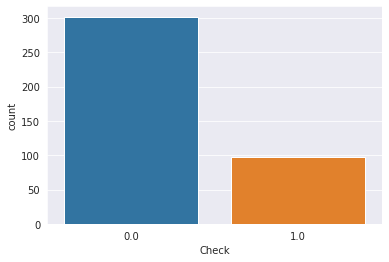

In [114]:
# proportion of salary offers accepted
sns.countplot(df_train['Check'])

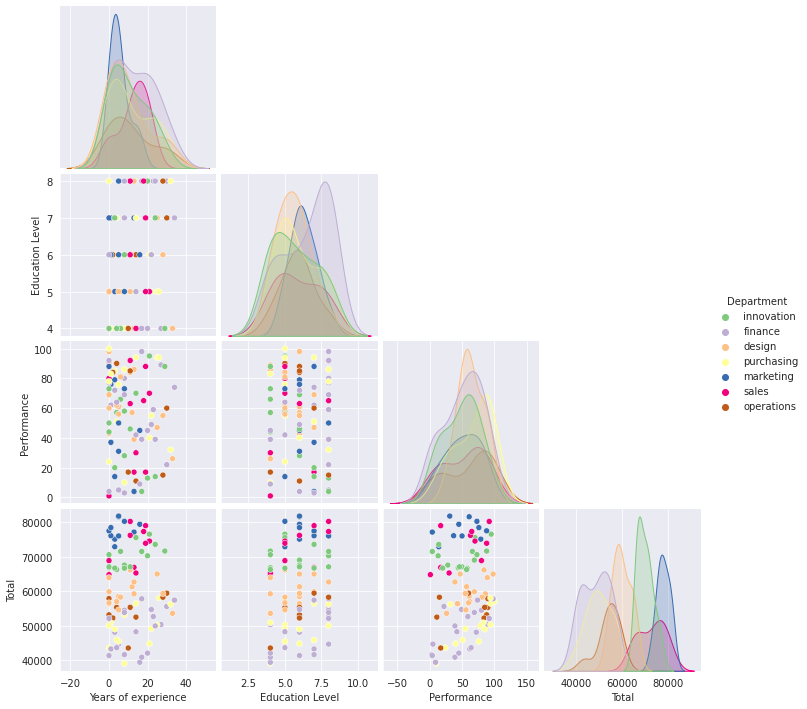

In [115]:
# Proving H1 and 2 --> plot numerical attributes that might have a relationship with 'Total'
# Proving H3 --> colour coordinate by department 
cols = ['Years of experience','Education Level', 'Department', 'Performance', 'Total']
df_1 = df_train.loc[df_train['Check']== 1]


sns.pairplot(df_1[cols], hue = 'Department', palette='Accent', corner=True, height=2.5)

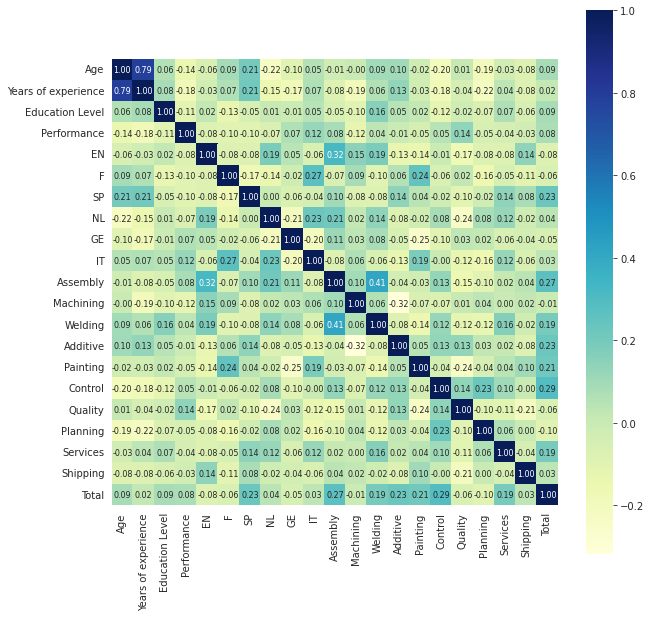

In [116]:
#showing correlation among variables
df_1 = df_1.drop('Check', axis=1)
fig, ax = plt.subplots(figsize=(10,10))  
corr = df_1.corr('spearman')
sns.heatmap(corr, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 8},
            cmap='YlGnBu')


When looking at the pairpot, we see H3 is correct:
- We can see a multimodal distribution when looking at the histogram for Total. From said Histogram, **we see that some colours/ departments have an overall higher 'Total' than the other Departments.**  

Looking at the correlation diagram, we see that H1 and H2 are also correct, but not significant. We therefore cannot single these out.

## 4. Supervised learning

As H1 and H2 were dismissed, we will continue the analysis using all 20 independant attributes. 
To ensure H3 is taken into account, a number will be assigned to each department, and mapped onto the column.  

The objective of the model is to classify the data into two categories. To choose the model, the follwoing data properties have to be considered: **high # of features, few observations, high variance**

Note that: 
*   **Linear SVM, linear modelling or Naive bayes (gnb)algorithms** are best for high bias, low variance data 
*   **SVM, random forest and neural nets** are best for  non-linear, high dimensional data. 
*   **KNN, Decision trees or kernel SVM** are best for when # festures << # observations. 


As we have a high number of variables, a tree-based approach will be tested (random forest, XGboost, decision tree), as well as using K-nearest neighbours (although a traditional method used fo rsuch exercises, as our trianing data is small, KNN might not work optimally). 

When carrying out the random tree algorithm, we see that the feature importance of languages and skills, are lower than that of perfoamnce, departmetn, education level, and years of experience. It might be a consideration to drop (or sum) the skills and language attributes if they obtain a higher accuracy and precision.   

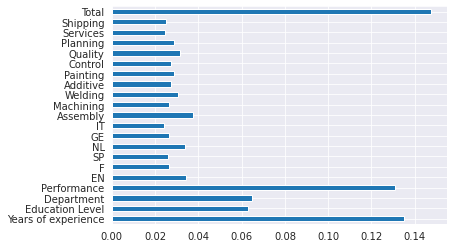

In [117]:
# assign numbers to departments for proper modelling further on
# create dictionary
lst = list(range(7))
lst_dep = df_train.Department.unique()
dep_dict = dict(zip(lst_dep, lst))

In [118]:
# map dictionary
df_train.Department = df_train.Department.map(dep_dict)
df_test.Department = df_test.Department.map(dep_dict)

In [119]:
# using the train dataset, drop any columns which are not needed for the model, and split into test and train data
'''df_tr = df_train.iloc[:,[6, 7, 8, 10, -2, -1]]
df_ts = df_test.iloc[:,[6, 7, 8, 10, -1]]'''

'df_tr = df_train.iloc[:,[6, 7, 8, 10, -2, -1]]\ndf_ts = df_test.iloc[:,[6, 7, 8, 10, -1]]'

In [120]:
# if we want to add the total number of skills 
lst_lan = ['EN', 'F', 'SP', 'NL', 'GE', 'IT']
df_train['Total Languages'] = df_train[lst_lan].sum(1, numeric_only=True)
df_test['Total Languages'] = df_test[lst_lan].sum(1, numeric_only=True)

lst_skills = ['Assembly', 'Machining', 'Welding', 'Additive', 'Painting', 'Control', 'Quality','Planning', 'Services', 'Shipping']
df_train['Total Skills'] = df_train[lst_skills].sum(1, numeric_only=True)
df_test['Total Skills'] = df_test[lst_skills].sum(1, numeric_only=True)


df_tr = df_train.iloc[:,[6, 7, 8, 10, -4, -3, -2, -1]]
df_ts = df_test.iloc[:,[6, 7, 8, 10, -3, -2, -1]]

In [121]:
# if we want to use all attributes
'''df_tr = df_train.iloc[:,6:]
df_tr = df_tr.drop('Country', axis=1)

df_ts = df_test.iloc[:,6:]
df_ts = df_ts.drop('Country', axis=1)'''

"df_tr = df_train.iloc[:,6:]\ndf_tr = df_tr.drop('Country', axis=1)\n\ndf_ts = df_test.iloc[:,6:]\ndf_ts = df_ts.drop('Country', axis=1)"

In [122]:
# take the train dataset and split into train and test for fitting of algorithm
X = df_tr.drop('Check', axis=1)
y = df_tr['Check']

# to check which model works best, we first need to check the perfromance of the algorithm
# as not too many datapoints exist, the data will be split 40:60 - to get sufficient stats. for the results

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

### RANDOM FOREST
A tree approach might be more suitable, as a high number of variables are used. 
This inlcudes random forest, xgboost, and the normal decision tree.

We see in the feature importance diagrams, how the algorithm differs in weighing attributes of the data differently. 

In [123]:
# random forest
rfc = RandomForestClassifier(n_estimators=100, random_state=0, oob_score= 'TRUE')
rfc.fit(X_train, y_train)
predictions_rf = rfc.predict(X_test)

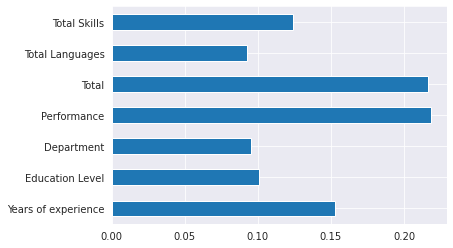

In [124]:
pd.Series(rfc.feature_importances_, index=X.columns).plot(kind='barh')

In [125]:
# rfc.predict_proba(X_test)

### DECISION TREE

In [126]:
# random forest
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions_dt = dtree.predict(X_test)

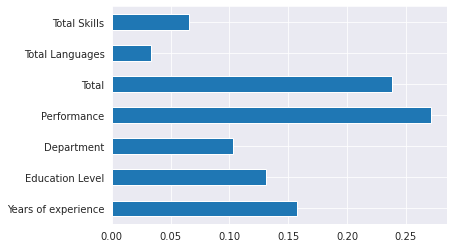

In [127]:
pd.Series(dtree.feature_importances_, index=X.columns).plot(kind='barh')

### XGBoost

(Gradient boosted decision trees)

In [128]:
xbg_model = XGBClassifier(gamma=0)
xbg_model.fit(X_train, y_train)
predictions_xbg = xbg_model.predict(X_test)

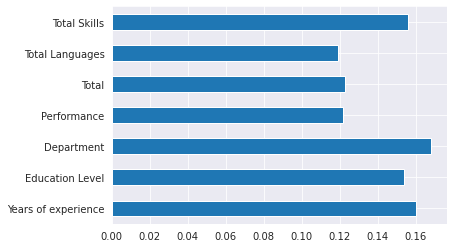

In [129]:
pd.Series(xbg_model.feature_importances_, index=X.columns).plot(kind='barh')

### k-NN


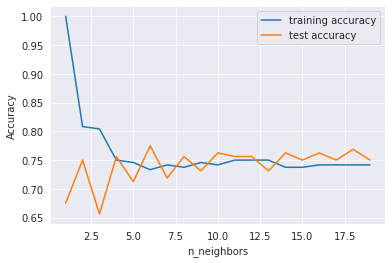

In [130]:
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 20)
for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

In [131]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_test)

### Prediction scores


In [132]:
print(classification_report(y_test, predictions_rf))
print("Accuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))

              precision    recall  f1-score   support

         0.0       0.77      0.88      0.82       124
         1.0       0.17      0.08      0.11        36

    accuracy                           0.70       160
   macro avg       0.47      0.48      0.47       160
weighted avg       0.63      0.70      0.66       160

Accuracy on training set: 1.000
Accuracy on test set: 0.700


In [133]:
print(classification_report(y_test, predictions_dt))
print("Accuracy on training set: {:.3f}".format(dtree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dtree.score(X_test, y_test)))

              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75       124
         1.0       0.21      0.25      0.23        36

    accuracy                           0.62       160
   macro avg       0.49      0.49      0.49       160
weighted avg       0.64      0.62      0.63       160

Accuracy on training set: 1.000
Accuracy on test set: 0.619


In [134]:
print(classification_report(y_test, predictions_xbg)) 
print("Accuracy on training set: {:.3f}".format(xbg_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xbg_model.score(X_test, y_test)))

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       124
         1.0       0.25      0.14      0.18        36

    accuracy                           0.71       160
   macro avg       0.51      0.51      0.50       160
weighted avg       0.66      0.71      0.68       160

Accuracy on training set: 0.908
Accuracy on test set: 0.713


In [135]:
print(classification_report(y_test, predictions_knn))
print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(knn.score(X_test, y_test)))

              precision    recall  f1-score   support

         0.0       0.77      0.92      0.84       124
         1.0       0.09      0.03      0.04        36

    accuracy                           0.72       160
   macro avg       0.43      0.47      0.44       160
weighted avg       0.61      0.72      0.66       160

Accuracy on training set: 0.742
Accuracy on test set: 0.719


## 5. Results & conclusion

From the above resutls, we see that the **xbg_model** approach is the best fitting for our data. 


Whilst other models have a higher overall accuracy, this model has the highest precision for class 1. We aim to obtain the highest precision (lowest false positives) from all models, to avoid overspending in budget for employees. (Reduce flase positives)

Furthermore, we know that about 66% of cases will not pass the Check (have a 0). At least 33% of cases should therefore be classified as 1 in the results. 



Using the provided testing data, and the full training dataset, the model was re-fit and a prediction for the check column was calcualted. 

The predicted data is then appended to the testing data set as our final output. 

In [164]:
X_train_1 = df_tr.drop('Check', axis=1)
y_train_1 = df_tr['Check']

xbg_model.fit(X_train_1, y_train_1)
y_pred = xbg_model.predict(df_ts)

In [165]:
y_pred

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [166]:
df_test['Check'] = y_pred

In [171]:
# return df to original state 
df_check = df_test.drop(['Total Languages', 'Total Skills'], axis=1)
dep_dict_2 = {v : k for k, v in dep_dict.items()}
df_check.Department =df_check.Department.replace(dep_dict_2)

In [172]:
df_check

,RecID,First Name,Surname,Gender,Age,Date of birth,Years of experience,Education Level,Department,Country,Performance,EN,F,SP,NL,GE,IT,Assembly,Machining,Welding,Additive,Painting,Control,Quality,Planning,Services,Shipping,Total,Check
0,1452477EZR,Kenneth,Scholle,male,41,1980-01-07,6,7,operations,Greece,92,0,0,0,1,1,1,1,1,0,1,0,1,1,1,0,1,62943.86569,0.0
1,4170288LHS,Harry,Ylonen,male,27,1994-02-12,1,5,operations,Portugal,87,1,0,1,0,1,1,1,0,0,0,0,1,0,1,1,1,54868.23450,0.0
2,9897633TAQ,Christopher,Agudo,male,54,1967-04-09,28,5,marketing,France,61,0,1,1,1,1,0,1,0,0,1,1,1,1,0,1,0,81153.96139,0.0
3,4288761AQH,Angela,Beckstrom,female,36,1985-01-15,0,7,sales,Finland,13,1,0,0,1,1,1,0,1,0,1,1,1,1,0,0,0,63008.15722,0.0
4,8852370IXZ,Mary,Alteri,female,29,1991-12-25,3,8,design,Czech Republic,11,1,0,0,1,0,1,1,0,1,1,0,0,1,1,1,1,59296.59316,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7923738YJB,Mary,Richardson,female,37,1984-11-17,7,4,sales,China,61,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,71800.17533,0.0
96,6777447RWH,Kenneth,Drake,male,28,1993-11-18,0,5,finance,China,91,1,1,0,0,0,0,1,1,0,1,1,0,0,0,0,0,47371.99562,0.0
97,8488383LDG,Joshua,Jackson,male,39,1982-04-27,13,4,design,Luxembourg,73,0,0,1,1,0,1,1,1,1,0,0,0,0,1,0,0,57766.83599,0.0
98,8480142IGP,Amanda,Lamb,female,27,1994-05-10,1,8,operations,United Kingdom,36,0,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,50633.64141,0.0


In [173]:
df_check.to_csv('/content/drive/Shareddrives/SIO - Group 2.1 (S1b)/A4 (14.01.2022)/A4_4_reworked.csv', sep=',')

In [174]:
df_check.Check.sum()

9.0

A total of 9/100 offers are accepted. 

Considering that in the training data, 33% was accepted, and out model is accurate to 71%, this number is lower than expected. 

This can probably be traced back to the lacking precision and accuracy of the model. 

This model was modelled based solely on historic data. If either:

1.   more datapoitns wuould be available (either to better train the model, or to be able to split departments to raise the correlation between attributes); or
2.   the HR team would provide specific attributes that weigh in more/ less during the decision process of accepting/rejecting candidates salaries; 

the model could further be improved. 

### Sources used:

https://yourdataguy.org/machine-learning-for-diabetes-prediction-in-python/

https://scikit-learn.org/

https://datascienceplus.com/machine-learning-for-diabetes-with-python/

https://blogs.sas.com/content/subconsciousmusings/2020/12/09/machine-learning-algorithm-use/


https://www.atlantis-press.com/journals/ijcis/25899235/view
